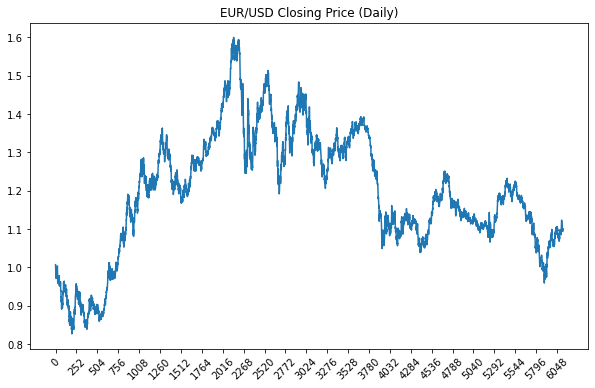

In [2]:
# Import data
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt

# Importing the excel file into the Python interpreter
data = pd.read_excel('Daily_EURUSD_Historical_Data.xlsx')
data=data['<CLOSE>']

plt.figure(figsize=(10, 6))
plt.plot(data)
plt.title('EUR/USD Closing Price (Daily)')

# Set xticks to appear every 252 days
plt.xticks(range(0, len(data), 252), rotation=45)  # 252 days = 1 year in trading days
plt.show()

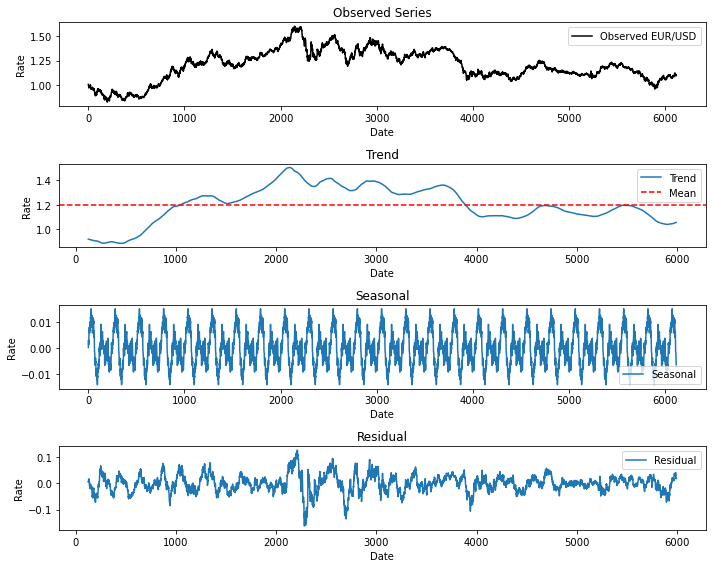

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the time series into trend, seasonal, and residual components
# Assuming yearly "seasonality" because we know FX rates exhibit long memory
# 252 is approximately the number of trading days in a year
decomposition = seasonal_decompose(data, model='additive', period=252)  

# Plot the observed series and its decomposition
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(data.index, data, label='Observed EUR/USD', color='black')  # Plotting the observed series
plt.title('Observed Series')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# We can think of the trend (or level) component as trying to draw a line through most of the data points 
# to show the general direction of a time series. Not going in one direction, consistent with reversion to the mean.
plt.subplot(412)
plt.plot(data.index, decomposition.trend, label='Trend')
plt.axhline(y=data.mean(), color='red', linestyle='--', label='Mean')  # Add a dashed line for the series mean
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Periodic fluctuations suggest yearly periodicity. Seasonal component shows how we deviate from the trend.
plt.subplot(413)
plt.plot(data.index, decomposition.seasonal, label='Seasonal')
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Residuals usually correspond to random errors, also termed white noise, which we cannot model or predict.
plt.subplot(414)
plt.plot(data.index, decomposition.resid, label='Residual')
plt.title('Residual')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
# Check for stationarity using ADF test

# The ADF test verifies the following null hypothesis: there is a unit root present in a time series. 
# The alternative hypothesis is that there is no unit root, and therefore the time series is stationary. 
# The result of this test is the ADF statistic, which is a negative number. 
# The more negative it is, the stronger the rejection of the null hypothesis. 
# In its implementation in Python, the p-value is also returned. 
# If its value is less than 0.05, we can also reject the null hypothesis and say the series is stationary.

from statsmodels.tsa.stattools import adfuller
# Define a function to perform the ADF test
def adf_test(timeseries):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Perform the ADF test on the time series data
adf_test(data)

# We cannot reject the null, so we have a unit root, and the time series is non-stationary. 

ADF Statistic: -1.9033253105249455
p-value: 0.3304984003937196
Critical Values:
	1%: -3.4314194860680893
	5%: -2.862012616190853
	10%: -2.5670215709027353


ADF Statistic: -79.74172073694271
p-value: 0.0
Critical Values:
	1%: -3.4314194860680893
	5%: -2.862012616190853
	10%: -2.5670215709027353


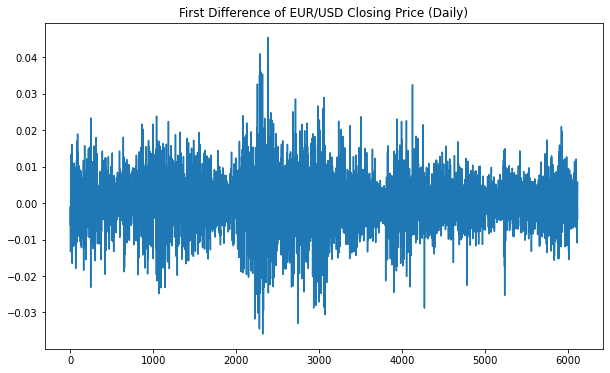

In [8]:
# Difference the data to make it stationary
datadiff = data.diff()
datadiff=datadiff.dropna()

plt.figure(figsize=(10, 6))
plt.plot(datadiff)
plt.title('First Difference of EUR/USD Closing Price (Daily)')

# Perform the ADF test on the time series data
adf_test(datadiff)

# First-differencing made our data stationary.

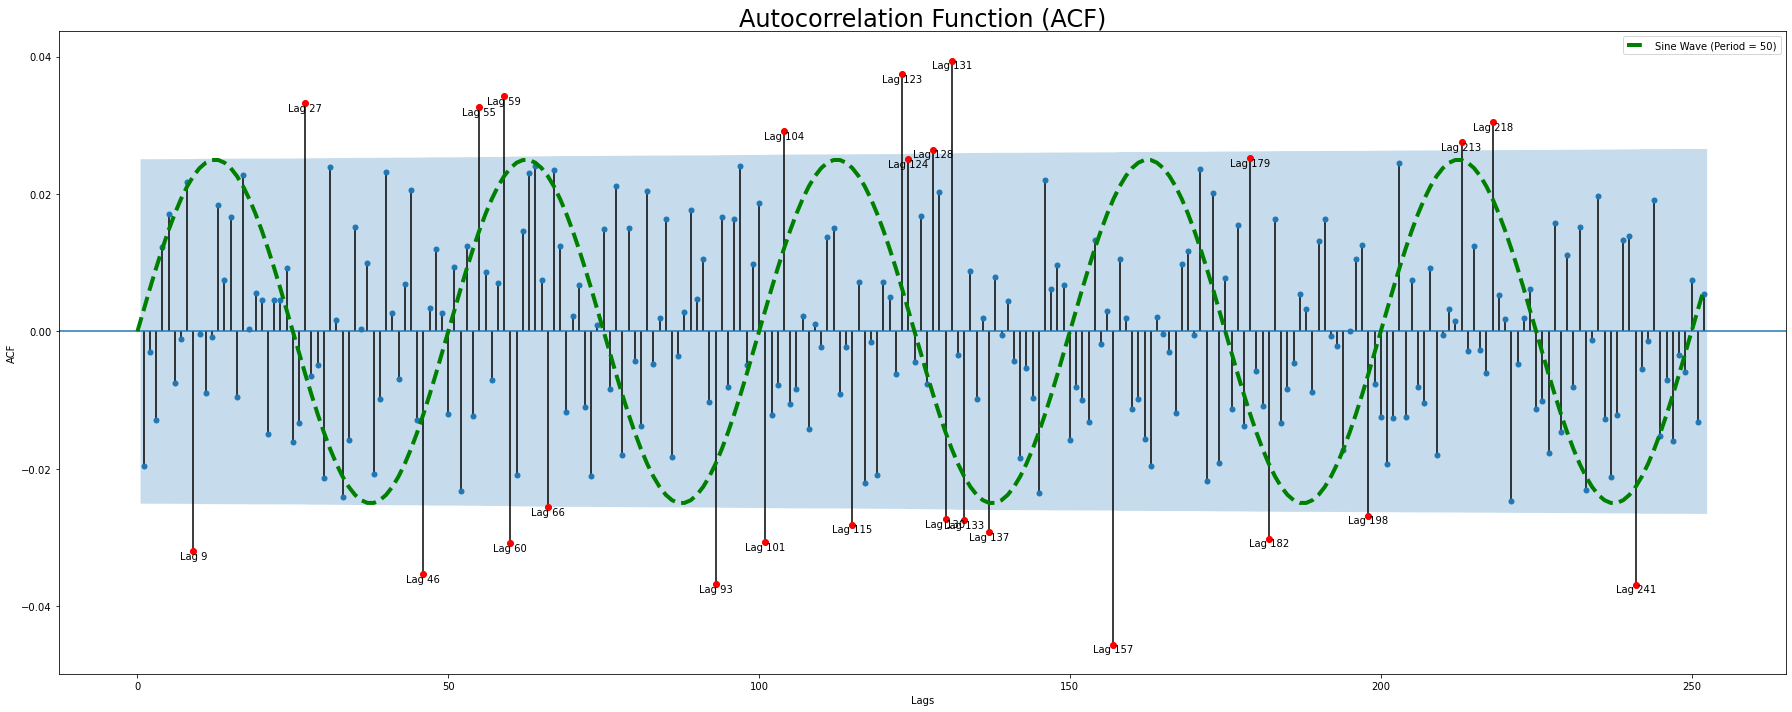

[9, 27, 46, 55, 59, 60, 66, 93, 101, 104, 115, 123, 124, 128, 130, 131, 133, 137, 157, 179, 182, 198, 213, 218, 241]


In [22]:
# Check for autocorrelation using ACF
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Compute the autocorrelation function (ACF) values and confidence interval at 95%
LAGS=252

acf_vals, confint = acf(datadiff, nlags=LAGS, alpha=0.05, fft=False) 
# # Exclude values for the 0 lag
acf_vals[0]=0
confint[0]=0
# lower_bound = confint[1:, 0] - acf_vals[1:]
# upper_bound = confint[1:, 1] - acf_vals[1:]
# print(lower_bound)

conf_int = 1.96 / np.sqrt(len(datadiff))  # 95% confidence interval

# Plot the autocorrelation function (ACF)
fig, ax = plt.subplots(figsize=(25, 10))
plot_acf(datadiff, lags=LAGS, ax=ax, zero=False, fft=False)  # Drop the 0 lag for better visibility. It always equals 1.
plt.title('Autocorrelation Function (ACF)', fontsize=24)
plt.xlabel('Lags')
plt.ylabel('ACF')

# Overlay a sine wave with a period of 50
lags = np.arange(0, len(acf_vals))
sine_wave = 0.025*np.sin(2 * np.pi * lags / 50)  # Period of 50
plt.plot(lags, sine_wave, label='Sine Wave (Period = 50)', linestyle='--', color='green', linewidth=4)
plt.legend()

# Highlight significant correlations
sig_points = np.where((acf_vals > conf_int) | (acf_vals < -conf_int))[0]
plt.scatter(sig_points, acf_vals[sig_points], color='red', zorder=3)

# Add labels for lag values associated with red dots
for lag in sig_points:
    plt.text(lag, acf_vals[lag], f'Lag {lag}', ha='center', va='top', fontsize=10)
         
plt.tight_layout() 
plt.show()

# We see a sinusoidal pattern, which indicates an autoregressive process

# Initialize an empty list to store the labels
labels_list = []

# Get list of lag values associated with significant lags
for lag in sig_points:
    labels_list.append(lag)

# Print the list of labels
print(labels_list)

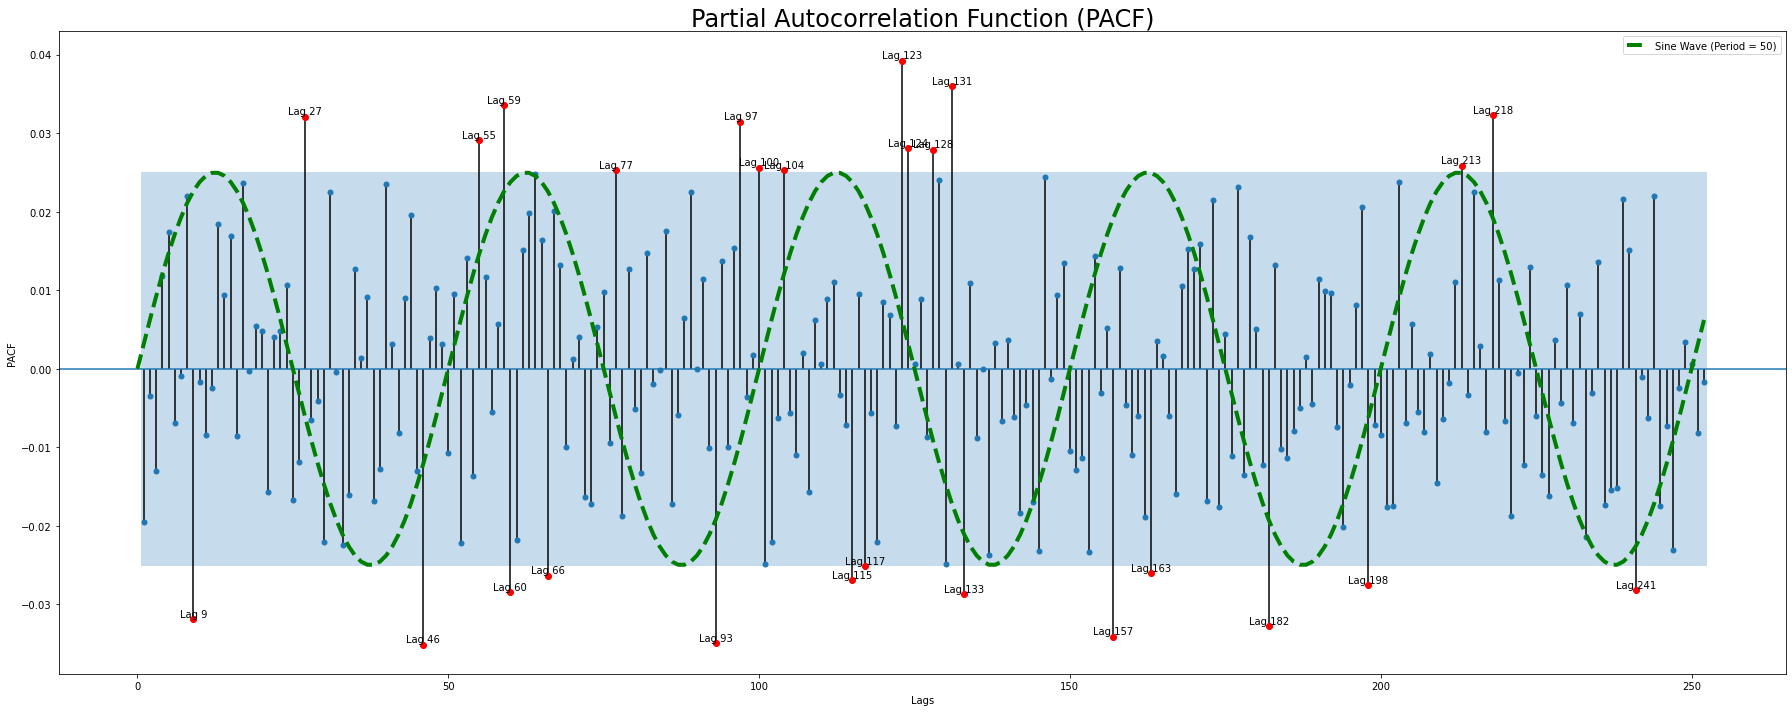

[9, 27, 46, 55, 59, 60, 66, 77, 93, 97, 100, 104, 115, 117, 123, 124, 128, 131, 133, 157, 163, 182, 198, 213, 218, 241]


In [24]:
# Check for autocorrelation using PACF
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

LAGS=252

pacf_vals, confintp = pacf(datadiff, nlags=LAGS, alpha=0.05) 
# # Exclude values for the 0 lag
pacf_vals[0]=0
confintp[0]=0

# Plot the partial autocorrelation function (PACF)
fig, ax = plt.subplots(figsize=(25, 10))
plot_pacf(datadiff, lags=LAGS, zero=False, ax=ax)  # You can adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF)', fontsize=24)
plt.xlabel('Lags')
plt.ylabel('PACF')

# Overlay a sine wave with a period of 50
lags = np.arange(0, len(acf_vals))
sine_wave = 0.025*np.sin(2 * np.pi * lags / 50)  # Period of 50
plt.plot(lags, sine_wave, label='Sine Wave (Period = 50)', linestyle='--', color='green', linewidth=4)
plt.legend()

# Highlight significant correlations
sig_points_p = np.where((pacf_vals > conf_int) | (pacf_vals < -conf_int))[0]
plt.scatter(sig_points_p, pacf_vals[sig_points_p], color='red', zorder=3)

# Add labels for lag values associated with red dots
for lag in sig_points_p:
    plt.text(lag, pacf_vals[lag], f'Lag {lag}', ha='center', va='bottom', fontsize=10)

plt.tight_layout() 
plt.show()

# PACF again shows a sinusoidal patters, so the PACF plot cannot be used to find the order p of an ARMA(p,q) process.
# If your process is stationary and both the ACF and PACF plots show a decaying or sinusoidal pattern, 
# then it is a stationary ARMA(p,q) process.

# Initialize an empty list to store the labels
labels_list_pacf = []

# Get list of lag values associated with significant lags
for lag in sig_points_p:
    labels_list_pacf.append(lag)

# Print the list of labels
print(labels_list_pacf)

In [28]:
# subtracted_list = [x - 1 for x in original_list]
print(labels_list)
print(labels_list_pacf)

[9, 27, 46, 55, 59, 60, 66, 93, 101, 104, 115, 123, 124, 128, 130, 131, 133, 137, 157, 179, 182, 198, 213, 218, 241]
[9, 27, 46, 55, 59, 60, 66, 77, 93, 97, 100, 104, 115, 117, 123, 124, 128, 131, 133, 157, 163, 182, 198, 213, 218, 241]
